In [2]:
import numpy as np
from kmodes.kmodes import KModes
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

random.seed(5)

%matplotlib inline

In [3]:
df=pd.read_csv("data/report_anonymous_clean.csv", sep=";", encoding = 'utf8')

# drop cols 'Unnamed 0'
df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [4]:
df.columns

Index(['ETA_PRELIEVO', 'DATA_PRELIEVO', 'DATA_ULTIMA_MESTRUAZIONE',
       'DATA_PAP_PRECEDENTE', 'FORNICE', 'PORTIO', 'CAN_CERV', 'CAV_UT',
       'PERDITE_ER', 'LEUCORREA', 'PRURITO', 'TER_RAD', 'TER_ORM',
       'GRAVIDANZE', 'ABORTI', 'TEST_ESTR', 'TER_ANTIF', 'OP_GIN', 'MENOPAUSA',
       'AMENORREA', 'POST_PARTUM', 'PRIMO_PAP', 'CITO_PREC', 'VIRALE_PREC',
       'BATT_PREC', 'CONTROLLO', 'CTRL_ISTOLOGICO', 'VALIDITA_CAMPIONE',
       'CAUSA_CAMPIONE_NON_VALIDO', 'BATT', 'CITO', 'VIRALE'],
      dtype='object')

In [56]:
data = df[['ETA_PRELIEVO', 'CITO', 'CITO_PREC', 'MENOPAUSA',]].copy()

data['ETA_PRELIEVO'] = pd.cut(data['ETA_PRELIEVO'], [10,25,35,45,55,65,75,90],\
                              labels=['10-25','25-35','35-45','45-55','55-65','65-75','75-90'])

data.dropna(inplace=True)
data = data.applymap(str)

data['CITO'].replace({'ASCUS':'C_POSITIVO', 'LSIL':'C_POSITIVO', 
                      'HSIL':'C_POSITIVO', 'AGC-NOS':'C_POSITIVO',
                      'AIS':'C_POSITIVO', 'ASC-H':'C_POSITIVO',
                      'SCC':'C_POSITIVO', 'AGC-NEOPLASTIC':'C_POSITIVO',
                      'NEGATIVO':'C_NEGATIVO'}, inplace=True)

data['CITO_PREC'].replace({'ASCUS':'CP_POSITIVO', 'LSIL':'CP_POSITIVO', 
                           'HSIL':'CP_POSITIVO', 'AGC-NOS':'CP_POSITIVO',
                           'AIS':'CP_POSITIVO', 'ASC-H':'CP_POSITIVO',
                           'SCC':'CP_POSITIVO', 'AGC-NEOPLASTIC':'CP_POSITIVO',
                           'NEGATIVO':'CP_NEGATIVO'}, inplace=True)

data['MENOPAUSA'].replace({'True':'M_TRUE', 'False':'M_FALSE'}, inplace=True)




print(len(data))

2006


In [59]:
def kmode_cluster(size):
    km = KModes(n_clusters=size, init='Cao', n_init=10, verbose=0)
    clusters = km.fit_predict(data)
    return km

def compute_error(km):
    error = {i: 0 for i in data['CLUSTER'].unique()}
    for index, row in data.iterrows():
        for i, item in enumerate(row[:-1]):
            if item != km.cluster_centroids_[row['CLUSTER']][i]:
                error[row['CLUSTER']] += 1
    
    cum_err = 0
    for i in error:
        cum_err += error[i]
        
    return error, cum_err

In [90]:
size = 5
errors = {i: 0 for i in range(2,size+1)}

for i in range(2,size+1):
    print("clustering with {} centroids...".format(i))
    km = kmode_cluster(i)
    data['CLUSTER'] = km.labels_
    print(km.cluster_centroids_)
    err, cum_err = compute_error(km)
    print("error per centroid: ",err)
    print("cumulative error: ",cum_err)
    errors[i] = cum_err
    print()

clustering with 2 centroids...
[['45-55' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_FALSE' '0']
 ['55-65' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_TRUE' '1']]
error per centroid:  {1: 98, 0: 1402}
cumulative error:  1500

clustering with 3 centroids...
[['45-55' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_FALSE' '0']
 ['55-65' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_TRUE' '1']
 ['35-45' 'C_POSITIVO' 'CP_POSITIVO' 'M_FALSE' '0']]
error per centroid:  {1: 98, 0: 1284, 2: 48}
cumulative error:  1430

clustering with 4 centroids...
[['45-55' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_FALSE' '0']
 ['55-65' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_TRUE' '1']
 ['35-45' 'C_POSITIVO' 'CP_POSITIVO' 'M_FALSE' '2']
 ['25-35' 'C_NEGATIVO' 'CP_POSITIVO' 'M_FALSE' '0']]
error per centroid:  {1: 98, 0: 1184, 3: 21, 2: 48}
cumulative error:  1351

clustering with 5 centroids...
[['45-55' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_FALSE' '0']
 ['55-65' 'C_NEGATIVO' 'CP_NEGATIVO' 'M_TRUE' '1']
 ['35-45' 'C_NEGATIVO' 'CP_POSITIVO' 'M_FALSE' '2']
 ['25-35' 'C_POSITIVO' 'CP_NEGATIVO' 'M_FAL

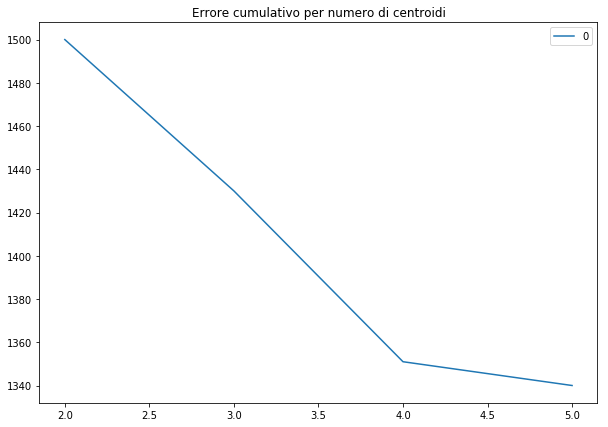

In [93]:
errors_df = pd.DataFrame.from_dict(errors, orient='index')
errors_df.plot(kind='line', title = 'Errore cumulativo per numero di centroidi', figsize=(10,7), legend=False)

In [55]:
#plt.figure(figsize=(15, 15))
#
#
#ax1 = plt.scatter(x=clusters, y=data['ETA_PRELIEVO'], color='b')   
#ax2 = plt.scatter(x=clusters, y=data['CITO'], color='r') 
#ax2 = plt.scatter(x=clusters, y=data['CITO_PREC'], color='c') 
#ax3 = plt.scatter(x=clusters, y=data['MENOPAUSA'], color='y') 